In [3]:
import zipfile
import os

# 設定
zip_path = "../archive.zip"       # ZIPファイルの名前
extract_to = "../image_data"            # 解凍先のフォルダ名

# 解凍処理
if os.path.exists(zip_path):
    print("解凍を開始します...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"完了！ '{extract_to}' フォルダに解凍しました。")
else:
    print(f"エラー: {zip_path} が見つかりません。")

解凍を開始します...
完了！ '../image_data' フォルダに解凍しました。


Using device: cpu
検出されたクラス: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
クラス数: 10
モデル作成完了
学習を開始します...
Epoch [1/10], Loss: 2.2870, Accuracy: 0.1577
Epoch [2/10], Loss: 2.0216, Accuracy: 0.2428
Epoch [3/10], Loss: 1.8902, Accuracy: 0.3141
Epoch [4/10], Loss: 1.7781, Accuracy: 0.3792
Epoch [5/10], Loss: 1.6682, Accuracy: 0.4218
Epoch [6/10], Loss: 1.5076, Accuracy: 0.4606
Epoch [7/10], Loss: 1.4031, Accuracy: 0.5094
Epoch [8/10], Loss: 1.2956, Accuracy: 0.5569
Epoch [9/10], Loss: 1.1562, Accuracy: 0.6158
Epoch [10/10], Loss: 1.0887, Accuracy: 0.6183
学習終了！
テストデータの正解率: 61.00%
学習曲線を loss_curve.png に保存しました。


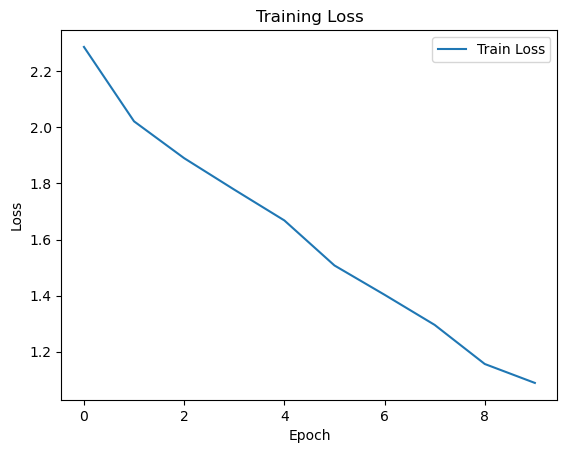

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# --- 1. 設定 ---
DATA_DIR = "../image_data/Data/images_original"       # 画像が入っているフォルダ名
BATCH_SIZE = 32         # 一度に学習する枚数
IMG_SIZE = 128          # 画像をこのサイズに統一する（64x64）
LEARNING_RATE = 0.001   # 学習率
EPOCHS = 10             # 学習を繰り返す回数

# デバイスの設定（GPUがあれば使う）
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- 2. データ読み込みと前処理 ---
# 写真はサイズがバラバラなので、Resizeで統一します
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # カラー画像(RGB)の正規化
])

# データセットの読み込み（フォルダ名がそのままラベルになります）
try:
    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
except Exception as e:
    print(f"エラー: '{DATA_DIR}' フォルダが見つかりません。場所を確認してください。")
    exit()

# クラス名（フォルダ名）の確認
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"検出されたクラス: {class_names}")
print(f"クラス数: {num_classes}")

# 訓練用(80%)とテスト用(20%)に分ける
generator = torch.Generator().manual_seed(42)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# generator を渡して分割する
train_data, test_data = random_split(full_dataset, [train_size, test_size], generator=generator)

# データローダーの作成
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. CNNモデルの定義 ---
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # 畳み込み層1 (入力:3チャンネル[RGB] -> 出力:32)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 畳み込み層2 (入力:32 -> 出力:64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 畳み込み層3 (入力:64 -> 出力:128) ★ここが増えています
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_input_size = 128 * 16 * 16
        
        # 全結合層
        self.fc = nn.Linear(self.fc_input_size, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1) # 一列に並べる
        x = self.fc(x)
        return x

# モデルの作成
model = CustomCNN(num_classes).to(DEVICE)
print("モデル作成完了")

# --- 4. 学習の準備 ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 5. 学習ループ ---
print("学習を開始します...")
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("学習終了！")

# --- 6. テスト（評価） ---
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"テストデータの正解率: {(correct / total) * 100:.2f}%")

# --- 7. グラフの保存（オプション） ---
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('loss_curve.png')
print("学習曲線を loss_curve.png に保存しました。")